# Map coordinates to traces

We only have GPS recordings starting on the 09.11.2021. All shipment data before that can not be mapped to any GPS recordings. Only trajectories starting at the 9th of November or later can be mapped. 

In [1]:
import pandas as pd
import datetime as dt
import numpy as np

In [263]:
path = r"C:\Users\rouma\Documents\BlueRock\LastThreeMonths\LastThreeMonths\C2396\A10168\gpsSeries.json"
df = pd.read_json(path)
shipment = pd.read_csv(r"C:\Users\rouma\Documents\BlueRock\shipmentData.csv")

In [136]:
### Get info about the current GPS device
deviceName = path.split('C2396\\')[1].split('\\')[0]
deviceName


'A10168'

In [265]:
from datetime import datetime, timedelta
shipment['PlannedDeparture'] = shipment['PlannedDeparture'].str[:16]
shipment['ActualDeparture'] = shipment['ActualDeparture'].str.slice(0,16)
shipment['PlannedArrival'] = shipment['PlannedArrival'].str[:16]
shipment['ActualArrival'] = shipment['ActualArrival'].str[:16]


In [266]:

shipment['PlannedDeparture'] = pd.to_datetime(shipment['PlannedDeparture']) + timedelta(hours = 1)
shipment['ActualDeparture'] = pd.to_datetime(shipment['ActualDeparture']) + timedelta(hours = 1)
shipment['PlannedArrival'] = pd.to_datetime(shipment['PlannedArrival']) + timedelta(hours = 1)
shipment['ActualArrival'] = pd.to_datetime(shipment['ActualArrival']) + timedelta(hours = 1)

shipment


,ShipmentID,GpsDevice,ShipmentDate,Sequence,AddrStart,AddrStartLat,AddrStartLong,AddrEnd,AddrEndLat,AddrEndLong,PlannedDeparture,ActualDeparture,PlannedArrival,ActualArrival
0,5174532,A11774,2021-11-12,1,341164,49.18858,-123.15751,340428,49.02361,-118.43361,2021-11-12 06:30:00,2021-11-12 06:47:00,2021-11-12 13:30:00,2021-11-12 14:31:00
1,5174532,A11774,2021-11-12,2,340428,49.02361,-118.43361,340163,49.29173,-117.66300,2021-11-12 14:00:00,2021-11-12 14:31:00,2021-11-12 15:15:00,2021-11-12 16:06:00
2,5174534,A13380,2021-11-12,1,341164,49.18858,-123.15751,339070,50.80768,-121.32717,2021-11-12 06:30:00,NaT,2021-11-12 11:00:00,NaT
3,5174534,A13380,2021-11-12,2,339070,50.80768,-121.32717,341111,51.63635,-121.30158,2021-11-12 11:30:00,NaT,2021-11-12 12:45:00,NaT
4,5174534,A13380,2021-11-12,3,341111,51.63635,-121.30158,339468,52.14118,-122.16024,2021-11-12 13:15:00,NaT,2021-11-12 14:15:00,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55859,5349676,A11774,2022-02-07,1,339847,49.89912,-97.22095,338715,49.83338,-99.91696,2022-02-07 12:30:00,NaT,2022-02-07 15:00:00,NaT
55860,5349677,A19160,2022-02-07,1,339481,45.48263,-73.71923,340702,45.67957,-74.04537,2022-02-07 12:12:00,2022-02-07 12:13:00,2022-02-07 12:42:00,2022-02-07 12:48:00
55861,5349679,A12533,2022-02-07,1,340055,50.47830,-104.57762,340554,51.21090,-102.50061,2022-02-07 15:30:00,NaT,2022-02-07 17:45:00,NaT
55862,5349683,A21371,2022-02-07,1,340119,44.58295,-80.91225,340808,43.70504,-79.58349,2022-02-07 07:45:00,2022-02-07 06:53:00,2022-02-07 10:15:00,2022-02-07 09:12:00


In [22]:
# df = df.iloc[::-1] #Turn df upside down
# df = df.reset_index()
# df.drop('index', axis = 1, inplace = True)
# df
type(shipment['PlannedDeparture'][0])

pandas._libs.tslibs.timestamps.Timestamp

### Match shipment time and location with recordings from the GPS device A17501
**Per trip**:
* Get the planned departure from the shipment file
* Compare the distances from the planned departure lat-lon tuple to tuples from the recording that are close it timewise


In [267]:
df['gpsAt'] = pd.to_datetime(df['gpsAt'])
df['gpsAt'] = df['gpsAt'].dt.tz_localize(None)
df['DeviceName'] = deviceName


In [268]:
device = shipment[shipment['GpsDevice'] == deviceName]
device = device.reset_index().drop('index', axis = 1) #= device.reset_index().drop('index', axis = 1, inplace = True)
device.sort_values('PlannedDeparture', inplace = True)
type(device['PlannedDeparture'][0])


pandas._libs.tslibs.timestamps.Timestamp

## Distance in km

In [8]:
from math import cos, asin, sqrt, pi
from datetime import datetime

def distanceInKm(lat1, lon1, lat2, lon2):
    p = pi/180
    a = 0.5 - cos((lat2-lat1)*p)/2 + cos(lat1*p) * cos(lat2*p) * (1-cos((lon2-lon1)*p))/2
    return 12742 * asin(sqrt(a))


In [269]:
df = df.iloc[::-1].reset_index().drop('index', axis = 1)
df

,alt,batPct,gpsAt,heading,lat,lon,speed,TraceID,DeviceName
0,1101,81,2021-11-09 21:29:48,202,50.9928,-113.9429,2,NaN,A9844
1,1037,81,2021-11-09 21:30:46,252,50.9927,-113.9461,8,NaN,A9844
2,1055,81,2021-11-09 21:32:25,0,50.9933,-113.9468,25,NaN,A9844
3,1020,82,2021-11-09 21:33:28,0,50.9987,-113.9468,38,NaN,A9844
4,1035,82,2021-11-09 21:33:34,318,50.9991,-113.9468,11,NaN,A9844
...,...,...,...,...,...,...,...,...,...
3861,682,100,2022-01-14 01:39:19,272,53.5135,-113.3833,4,NaN,A9844
3862,684,100,2022-01-14 01:39:46,338,53.5137,-113.3842,8,NaN,A9844
3863,692,100,2022-01-14 01:40:01,330,53.5142,-113.3845,14,NaN,A9844
3864,690,100,2022-01-14 01:40:13,248,53.5143,-113.3850,9,NaN,A9844


In [244]:
# dept = device['PlannedDeparture'][0]
# dfTimeframe = df[(df['gpsAt'] >= '2021-11-11 23:33:55') & (df['gpsAt'] <= '2021-11-12 23:33:55')]#(df['gpsAt'] <= dept)]
# dept

#should be dept instead of hard coded values

Timestamp('2021-11-12 19:30:00')

In [142]:
#Create a new column in which we will iteratively fill the ShipmentIDs to map traces to the GPS sequences
df['TraceID'] = np.nan


## Get departure time and place 

In [261]:
def getMostProbableDeparture(dfTargetDeparture, dfTimeframeDept, plannedDeparture):
    if len(dfTargetDeparture) > 0:
        # if dfTargetDeparture['gpsAt'].diff().max() > dt.timedelta(minutes = 10):
        #     departureIndex = dfTargetDeparture[dfTargetDeparture['gpsAt'].diff() > dt.timedelta(minutes = 10)].iloc[0].name + 1
        #     return departureIndex
        # else: 
            
            #If there are multiple possible values, take the one that is closest to the planned departure date
            #indexOfLastZeroSpeed = dfTargetDeparture.index.to_list()[-1]

            indexOfLastZeroSpeed = dfTargetDeparture.index.to_list()[-1]
            timesFromPlannedDept = dfTargetDeparture['gpsAt'] - plannedDeparture
            dfTargetDeparture['timesFromPlannedDept'] = [abs(x.total_seconds()) for x in timesFromPlannedDept]
            closestValue = dfTargetDeparture[dfTargetDeparture['timesFromPlannedDept'] == dfTargetDeparture['timesFromPlannedDept'].min()]
            indexOfLastZeroSpeed = closestValue.index.to_list()[0]
            print('Index: ' + str(indexOfLastZeroSpeed))            
            try:
                departureIndex = dfTimeframeDept.loc[indexOfLastZeroSpeed + 1].name
            except:#If there is only one possible coordinate that was both close enough and slow enough we just take it
                departureIndex = dfTimeframeDept.loc[indexOfLastZeroSpeed].name

            return departureIndex
    #If there are no coordinates in the vicinity, we return a nan Index
    return np.nan
    
#getMostProbableDeparture(dfTargetDeparture)
#device.iloc[10]

In [82]:
# Get the time frame in which the departure may be. 
def getDepartureIndex(shipmentNo):
    currentTrace = device.iloc[shipmentNo]
    plannedDeparture = currentTrace['PlannedDeparture']

    #Get the list of all possible lat-lon tuples
    dfTimeframeDept = df[(df['gpsAt'] >= plannedDeparture - pd.Timedelta(hours = 3)) & (df['gpsAt'] < plannedDeparture + pd.Timedelta(hours = 3))]
    
    #Calculate the distance between all of them individually with the start tupkle
    distances = [distanceInKm(lat1, lon1, currentTrace['AddrStartLat'], currentTrace['AddrStartLong']) for lat1, lon1 in zip(dfTimeframeDept['lat'], dfTimeframeDept['lon'])]
    dfTimeframeDept['distanceFromDeparture'] = distances

    # We can read off the subset df where and when it most probably started
    dfTimeframeDept[(dfTimeframeDept['distanceFromDeparture'] < 1) & (dfTimeframeDept['speed'] < 100)]


    dfTargetDept = dfTimeframeDept[(dfTimeframeDept['distanceFromDeparture'] < 1) & (dfTimeframeDept['speed'] <= 5)]
    departureIndex = getMostProbableDeparture(dfTargetDept, dfTimeframeDept, plannedDeparture)
    dfTargetDept
    return departureIndex
#departureIndex = getDepartureIndex(71)
#df.loc[departureIndex]


# Get arrival time and place

In [228]:
#Get the most probable arrival date and time
def getMostProbableArrival(dfTargetArrival, dfTimeframeArrival):
    if len(dfTargetArrival) > 0:
        if dfTargetArrival['gpsAt'].diff().max() > dt.timedelta(minutes = 10):
            arrivalIndex = dfTargetArrival[dfTargetArrival['gpsAt'].diff() > dt.timedelta(minutes = 10)].iloc[0].name - 1
            #print('Large Timedelta Arrival')
        else: 
            indexOfLastZeroSpeed = dfTargetArrival.index.to_list()[-1]
            
            if len(dfTargetArrival) > 1:
                arrivalIndex = dfTimeframeArrival.loc[indexOfLastZeroSpeed - 1].name
                #arrivalIndex = dfTargetArrival.loc[indexOfLastZeroSpeed - 1].name
            else:
                arrivalIndex = dfTimeframeArrival.loc[indexOfLastZeroSpeed].name
                #arrivalIndex = dfTargetArrival.loc[indexOfLastZeroSpeed - 1].name
            return arrivalIndex
        return arrivalIndex
    return np.nan

In [15]:
# Get the time frame in which the arrival may be. 
dfTarget = None
def getArrivalIndex(shipmentNo):
    if departureIndex is not np.nan:
        currentTrace = device.iloc[shipmentNo]
        plannedArrival = (currentTrace['PlannedArrival'] - currentTrace['PlannedDeparture']) +df.loc[departureIndex]['gpsAt']
        #Get the list of all possible lat-lon tuples
        dfTimeframeArrival = df[(df['gpsAt'] >= plannedArrival - pd.Timedelta(hours = 6)) & (df['gpsAt'] < plannedArrival + pd.Timedelta(hours = 6))]

        #Calculate the distance between all of them individually with the start tupkle
        distances = [distanceInKm(lat1, lon1, currentTrace['AddrEndLat'], currentTrace['AddrEndLong']) for lat1, lon1 in zip(dfTimeframeArrival['lat'], dfTimeframeArrival['lon'])]
        dfTimeframeArrival['distanceFromArrival'] = distances

        # We can read off the subset df where and when it most probably started
        dfTargetArrival = dfTimeframeArrival[(dfTimeframeArrival['distanceFromArrival'] < 1) & (dfTimeframeArrival['speed'] < 30)]
        #dfTimeframe.loc[dfTimeframe['distanceFromArrival'].idxmin()]
        #arrival = dfTimeframe[dfTimeframe['distanceFromArrival']==dfTimeframe['distanceFromArrival'].min()]
        #arrival


        arrivalIndex = getMostProbableArrival(dfTargetArrival, dfTimeframeArrival)
        dfTarget = dfTargetArrival
        #return [arrivalIndex, dfTargetArrival]
        return arrivalIndex
    return np.nan
#arrivalIndex = getArrivalIndex(72)
#df.loc[arrivalIndex]


,alt,batPct,gpsAt,heading,lat,lon,speed,TraceID,distanceFromDeparture
765,-69,100,2021-11-12 04:39:31,178,45.4829,-73.7185,0,NaN,0.064345
766,0,100,2021-11-12 04:39:54,270,45.4843,-73.7194,16,NaN,0.186168
767,-3,100,2021-11-12 04:40:06,206,45.4838,-73.7197,21,NaN,0.135160
768,3,100,2021-11-12 04:40:15,204,45.4833,-73.7199,22,NaN,0.090988
769,8,100,2021-11-12 04:40:25,278,45.4831,-73.7203,11,NaN,0.098437
...,...,...,...,...,...,...,...,...,...
1080,19,100,2021-11-12 08:11:52,52,46.7492,-71.1894,95,5214565_1,240.520830
1081,19,100,2021-11-12 08:11:55,40,46.7498,-71.1886,99,5214565_1,240.609000
1082,19,100,2021-11-12 08:12:58,26,46.7635,-71.1780,97,5214565_1,242.144439
1083,43,100,2021-11-12 08:14:01,26,46.7771,-71.1675,98,5214565_1,243.669490


In [16]:
#Get the departure and arrival index and assign the ShipmentID as to rows in between

def assignTraceID(df, device, departureIndex, arrivalIndex, i):
    try:
        if (departureIndex is not np.nan) & (arrivalIndex is not np.nan): 
            df.loc[departureIndex : arrivalIndex, 'TraceID'] = str(device.iloc[i]['ShipmentID']) + '_' + str(device.iloc[i]['Sequence'])
    except:
        return 'Error'

#assignTraceID(df,device, 1,10, 8)


### Loop through all the different traces, grouped by ShipmentDate and ShipmentID
* Record the calculated arrival and departure dates
* Compare them to the planned and actual departure and arrival dates in the Excel files 

In [270]:
df['TraceID'] = np.nan
device = shipment[shipment['GpsDevice'] == 'A17501']
device = device.reset_index().drop('index', axis = 1) #= device.reset_index().drop('index', axis = 1, inplace = True)
device.sort_values('PlannedDeparture', inplace = True)


for i in range(len(device)):
    
    departureIndex = getDepartureIndex(i)
    arrivalIndex = getArrivalIndex(i)
    print(i, departureIndex, arrivalIndex, device.iloc[i]['ShipmentID'])
    assignTraceID(df, device, departureIndex, arrivalIndex, i)
    

0 nan nan 5195606
1 nan nan 5197702
2 nan nan 5205215
3 nan nan 5201972
4 nan nan 5203952
5 nan nan 5207159
6 nan nan 5214565
7 nan nan 5183671
8 nan nan 5183671
9 nan nan 5183671
10 nan nan 5182937
11 nan nan 5217790
12 nan nan 5217796
13 nan nan 5217796
14 nan nan 5217796
15 nan nan 5219816
16 nan nan 5221628
17 nan nan 5222940
18 nan nan 5225185
19 nan nan 5225693
20 nan nan 5226890
21 nan nan 5227803
22 nan nan 5230131
23 nan nan 5236892
24 nan nan 5236892
25 nan nan 5239283
26 nan nan 5241061
27 nan nan 5242322
28 nan nan 5255929
29 nan nan 5257138
30 nan nan 5260661
31 nan nan 5264156
32 nan nan 5264665
33 nan nan 5265328
34 nan nan 5279410
35 nan nan 5279631
36 nan nan 5280656
37 nan nan 5281656
38 nan nan 5294396
39 nan nan 5291331
40 nan nan 5293127
41 nan nan 5286471
42 nan nan 5286471
43 nan nan 5290612
44 nan nan 5284634
45 nan nan 5290612
46 nan nan 5290612
47 nan nan 5289315
48 nan nan 5290613
49 nan nan 5289315
50 nan nan 5289315
51 nan nan 5287807
52 nan nan 5285926
53 

In [256]:
df.loc[2123]

alt                           170
batPct                        100
gpsAt         2021-11-30 12:34:28
heading                       200
lat                       47.5976
lon                      -52.7351
speed                          71
DeviceName                 A10183
TraceID                       NaN
Name: 2123, dtype: object

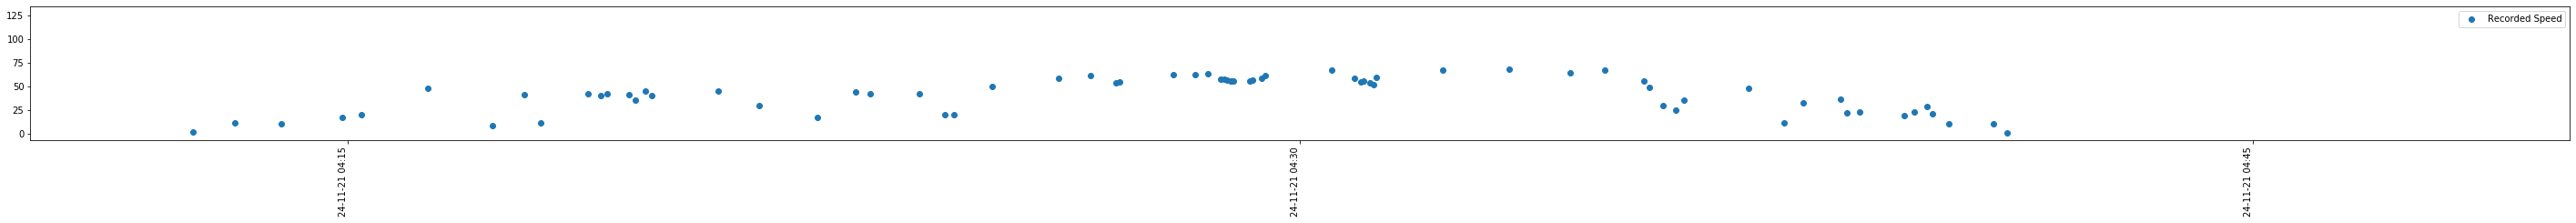

In [176]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates


from matplotlib.pyplot import figure


fig, ax = plt.subplots(1)
fig.autofmt_xdate()

plt.xticks(rotation=90)
plt.scatter(df['gpsAt'], df['speed'], label = 'Recorded Speed')
#plt.scatter(dates, df['avgSpeed'], label = 'Calculated Speed')

xfmt = mdates.DateFormatter('%d-%m-%y %H:%M')
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=15))
#ax.xaxis.set_major_locator(mdates.HourLocator(interval=3))
ax.xaxis.set_major_formatter(xfmt)
plt.rcParams["figure.figsize"] = (50,2)

plt.legend(loc="upper right")
plt.xlim(datetime(2021,11,24,4,10,0), datetime(2021,11,24,4,50,0) )
#plt.xlim(startDt, endDt)
plt.show()

### Get planned duration of trips

In [294]:
def addInformationAboutTrace(df, device):
    traceList = df['TraceID'].unique()

    traceList = [x for x in traceList if str(x) != 'nan']
    timeDiffList = [(df[df['TraceID'] == traceID].iloc[-1]['gpsAt']) - (df[df['TraceID'] == traceID].iloc[0]['gpsAt']) for traceID in traceList[1:]]

    #timeDiffList = [(df[df['TraceID'] == traceID].iloc[-1]['gpsAt']) - (df[df['TraceID'] == traceID].iloc[0]['gpsAt']) for traceID in traceList[1:]]

    diff = {}

    for i in range(len(traceList) - 1):
        diff[traceList[i + 1]] = timeDiffList[i]

    diffFrame = pd.DataFrame(columns = ['TraceID', 'Duration'])
    diffFrame['TraceID'] = diff.keys()
    diffFrame['Duration'] = diff.values()
    diffFrame['Duration'] = [x.total_seconds() / 60 for x in diffFrame['Duration'].to_list()]
    device['TraceID'] = device['ShipmentID'].astype(str) + '_' + device['Sequence'].astype(str)
    dfMerge = pd.merge(diffFrame, device, left_on='TraceID', right_on='TraceID', how= 'left')
    dfMerge['PlannedDuration'] = dfMerge['PlannedArrival'] - dfMerge['PlannedDeparture'] 



    diffFrame['PlannedDuration'] = [x.total_seconds() / 60 for x in dfMerge['PlannedDuration'].to_list()]

    ### Add Start and End 'Address' to the diffFrame
    diffFrame = pd.merge(diffFrame, device[['TraceID', 'AddrStart', 'AddrEnd']], left_on = 'TraceID', right_on = 'TraceID', how ='left')
    diffFrame['TraceNo'] = deviceName
    diffFrame['TimeDifference'] = diffFrame['Duration'] - diffFrame['PlannedDuration'] 

    diffFrame['Anomaly'] = 'No'
    #diffFrame.loc[diffFrame['TimeDifference'] > 15, 'Anomaly'] = 'Yes'
    diffFrame.loc[diffFrame['TimeDifference'] < -15, 'Anomaly'] = 'Yes'
    return diffFrame

## Testing
Test of departureIndex calculation

In [260]:

currentTrace = device.iloc[1]
plannedDeparture = currentTrace['PlannedDeparture']

#Get the list of all possible lat-lon tuples
dfTimeframeDept = df[(df['gpsAt'] >= plannedDeparture - pd.Timedelta(hours = 3)) & (df['gpsAt'] < plannedDeparture + pd.Timedelta(hours = 3))]

#Calculate the distance between all of them individually with the start tupkle
distances = [distanceInKm(lat1, lon1, currentTrace['AddrStartLat'], currentTrace['AddrStartLong']) for lat1, lon1 in zip(dfTimeframeDept['lat'], dfTimeframeDept['lon'])]
dfTimeframeDept['distanceFromDeparture'] = distances

# We can read off the subset df where and when it most probably started
dfTimeframeDept[(dfTimeframeDept['distanceFromDeparture'] < 1) & (dfTimeframeDept['speed'] < 100)]


dfTargetDept = dfTimeframeDept[(dfTimeframeDept['distanceFromDeparture'] < 1) & (dfTimeframeDept['speed'] <= 10)]
#departureIndex = getMostProbableDeparture(dfTargetDept, dfTimeframeDept, plannedDeparture)

'''timeFromPlannedDept = dfTargetDept['gpsAt'] - plannedDeparture
dfTargetDept['timeFromDept'] = [abs(x.total_seconds()) for x in timeFromPlannedDept]
dfTargetDept[dfTargetDept['timeFromDept'] == dfTargetDept['timeFromDept'].min()].index.to_list()[0]
dfTimeframeDept.loc[3].name'''
if len(dfTargetDept) > 0:
        
        # if dfTargetDept['gpsAt'].diff().max() > dt.timedelta(minutes = 10):
        #     departureIndex = dfTargetDept[dfTargetDept['gpsAt'].diff() > dt.timedelta(minutes = 10)].iloc[0].name + 1
            
        # else: 
            
            #If there are multiple possible values, take the one that is closest to the planned departure date
            #indexOfLastZeroSpeed = dfTargetDeparture.index.to_list()[-1]

            indexOfLastZeroSpeed = dfTargetDept.index.to_list()[-1]
            timesFromPlannedDept = dfTargetDept['gpsAt'] - plannedDeparture
            dfTargetDept['timesFromPlannedDept'] = [abs(x.total_seconds()) for x in timesFromPlannedDept]
            closestValue = dfTargetDept[dfTargetDept['timesFromPlannedDept'] == dfTargetDept['timesFromPlannedDept'].min()]
            indexOfLastZeroSpeed = closestValue.index.to_list()[0]
            # timesFromDeptList = [abs(x.total_seconds()) for x in timesFromPlannedDept]
            # indexOfLastZeroSpeed = timesFromDeptList[0]
            print('Index: ' + str(indexOfLastZeroSpeed))            
            try:
                departureIndex = dfTimeframeDept.loc[indexOfLastZeroSpeed + 1].name
            except:#If there is only one possible coordinate that was both close enough and slow enough we just take it
                departureIndex = dfTimeframeDept.loc[indexOfLastZeroSpeed].name
#df[100:130]


arrivalIndex calculation test

In [151]:
'''if departureIndex is not np.nan:
    currentTrace = device.iloc[72]
    plannedArrival = (currentTrace['PlannedArrival'] - currentTrace['PlannedDeparture']) +df.loc[departureIndex]['gpsAt']
    #Get the list of all possible lat-lon tuples
    dfTimeframeArrival = df[(df['gpsAt'] >= plannedArrival - pd.Timedelta(hours = 6)) & (df['gpsAt'] < plannedArrival + pd.Timedelta(hours = 6))]

    #Calculate the distance between all of them individually with the start tupkle
    distances = [distanceInKm(lat1, lon1, currentTrace['AddrEndLat'], currentTrace['AddrEndLong']) for lat1, lon1 in zip(dfTimeframeArrival['lat'], dfTimeframeArrival['lon'])]
    dfTimeframeArrival['distanceFromArrival'] = distances

    # We can read off the subset df where and when it most probably started
    dfTargetArrival = dfTimeframeArrival[(dfTimeframeArrival['distanceFromArrival'] < 1) & (dfTimeframeArrival['speed'] < 30)]
    #dfTimeframe.loc[dfTimeframe['distanceFromArrival'].idxmin()]
    #arrival = dfTimeframe[dfTimeframe['distanceFromArrival']==dfTimeframe['distanceFromArrival'].min()]
    #arrival


    arrivalIndex = getMostProbableArrival(dfTargetArrival, dfTimeframeArrival)
    dfTarget = dfTargetArrival
#df.loc[arrivalIndex]
dfTimeframeArrival'''
df[df['TraceID'] == '5295353_1']

,alt,batPct,gpsAt,heading,lat,lon,speed,DeviceName,TraceID
3243,653,100,2022-01-07 13:41:55,286,53.4679,-113.4914,14,A10168,5295353_1
3244,656,100,2022-01-07 13:42:10,288,53.4680,-113.4918,13,A10168,5295353_1
3245,657,100,2022-01-07 13:42:19,338,53.4683,-113.4922,19,A10168,5295353_1
3246,655,100,2022-01-07 13:43:19,0,53.4759,-113.4922,55,A10168,5295353_1
3247,653,100,2022-01-07 13:43:31,0,53.4775,-113.4921,48,A10168,5295353_1
...,...,...,...,...,...,...,...,...,...
3309,657,100,2022-01-07 14:03:07,266,53.5631,-113.6161,26,A10168,5295353_1
3310,655,100,2022-01-07 14:03:58,266,53.5632,-113.6234,21,A10168,5295353_1
3311,643,100,2022-01-07 14:04:10,356,53.5634,-113.6238,8,A10168,5295353_1
3312,642,100,2022-01-07 14:04:31,350,53.5640,-113.6238,9,A10168,5295353_1


# Write partitioned trace to DB

In [227]:
import sqlite3

def GPSRecordingsToDB(df):
    try:
        conn = sqlite3.connect(r'C:\Users\rouma\Documents\BlueRock\TraceDB.db')
        cursor = conn.cursor()
        df.to_sql('Trace_A17501', conn, if_exists='append', index = False)
        conn.commit()
        
        print("Insert complete")
        
        cursor.execute('''  
    SELECT * FROM Trace_A17501 LIMIT 100
            ''')

        # for row in cursor.fetchall():
        #     print (row)
        #     cursor.close()

    except sqlite3.Error as error:
        print("Error while connecting to sqlite", error)
    finally:
        if conn:
            conn.close()
            print("The SQLite connection is closed")

## Write Trace Info to DB

In [226]:
import sqlite3
def traceInfoToDB(diffFrame):
    try:
        conn = sqlite3.connect(r'C:\Users\rouma\Documents\BlueRock\TraceDB.db')
        cursor = conn.cursor()
        diffFrame.to_sql('A17501_Info', conn, if_exists='append', index = False)
        conn.commit()
        
        print("Insert complete")
        
        cursor.execute('''  
    SELECT * FROM A17501_Info LIMIT 100
            ''')

        # for row in cursor.fetchall():
        #     print (row)
        #     cursor.close()

    except sqlite3.Error as error:
        print("Error while connecting to sqlite", error)
    finally:
        if conn:
            conn.close()
            print("The SQLite connection is closed")

In [295]:
'A21548' < 'A9844'


True

In [281]:
from datetime import datetime, timedelta
def preprocessShipmentData(shipment):
    shipment['PlannedDeparture'] = shipment['PlannedDeparture'].str[:16]
    shipment['ActualDeparture'] = shipment['ActualDeparture'].str.slice(0,16)
    shipment['PlannedArrival'] = shipment['PlannedArrival'].str[:16]
    shipment['ActualArrival'] = shipment['ActualArrival'].str[:16]

    shipment['PlannedDeparture'] = pd.to_datetime(shipment['PlannedDeparture']) + timedelta(hours = 1)
    shipment['ActualDeparture'] = pd.to_datetime(shipment['ActualDeparture']) + timedelta(hours = 1)
    shipment['PlannedArrival'] = pd.to_datetime(shipment['PlannedArrival']) + timedelta(hours = 1)
    shipment['ActualArrival'] = pd.to_datetime(shipment['ActualArrival']) + timedelta(hours = 1)


def preProcessGPSRecording(df, shipment):
    print('preProcessGPSRecording')
    device = pd.DataFrame()
    if not df.empty:
        df['gpsAt'] = pd.to_datetime(df['gpsAt'])
        df['gpsAt'] = df['gpsAt'].dt.tz_localize(None)
        df['DeviceName'] = deviceName

        device = shipment[shipment['GpsDevice'] == deviceName]
        device = device.reset_index().drop('index', axis = 1) #= device.reset_index().drop('index', axis = 1, inplace = True)
        device.sort_values('PlannedDeparture', inplace = True)

        df = df[::-1].reset_index().drop('index', axis = 1)
        df['TraceID'] = np.nan
    return [df, device]

# Whole Process

In [296]:
import os
rootdir = r"C:\Users\rouma\Documents\BlueRock\LastThreeMonths\LastThreeMonths\C2396"

for subdir, dirs, files in os.walk(rootdir):
        for file in files:
            if file == 'gpsSeries.json': 
                pathName = os.path.join(subdir, file)
                deviceName = pathName.split('C2396\\')[1].split('\\')[0]
                if deviceName >= 'A21548':
                    print(pathName.split('C2396\\')[1].split('\\')[0])
                    df = pd.read_json(pathName)
                    
                    preProcessedDfAndDevice = preProcessGPSRecording(df, shipment)
                    device = preProcessedDfAndDevice[1]
                    df = preProcessedDfAndDevice[0]

                    #if not (device.empty or df.empty):
                    if (not device.empty) and (not df.empty):
                        df['TraceID'] = np.nan
                        for i in range(len(device)):
                            departureIndex = getDepartureIndex(i)
                            arrivalIndex = getArrivalIndex(i)
                            print(i, departureIndex, arrivalIndex, device.iloc[i]['ShipmentID'])
                            assignTraceID(df, device, departureIndex, arrivalIndex, i)

                        diffFrame = addInformationAboutTrace(df, device)

                        GPSRecordingsToDB(df)
                        traceInfoToDB(diffFrame)

            

A21548
preProcessGPSRecording
Index: 0
0 0 2 5212640
Index: 13
1 14 27 5214174
Index: 36
2 37 191 5215761
Index: 354
3 355 370 5221304
Index: 379
4 380 412 5223453
Index: 440
5 441 460 5224853
Index: 464
6 465 711 5225587
Index: 1543
7 1544 1554 5231206
Index: 1555
8 1556 1559 5231206
Index: 1564
9 1565 1568 5232592
Index: 1808
10 1809 1821 5234836
Index: 1823
11 1824 nan 5234862
Index: 2457
12 2458 2462 5239198
Index: 2977
13 2978 3020 5230536
Index: 3040
14 3041 3109 5229156
Index: 3114
15 3115 3276 5244717
16 nan nan 5244717
Index: 3978
17 3979 3982 5254719
Index: 4212
18 4213 4237 5258791
19 nan nan 5259558
Index: 4287
20 4287 4314 5260105
Index: 4547
21 4548 nan 5254031
22 nan nan 5254031
Index: 4558
23 4559 nan 5264351
24 nan nan 5249261
Index: 4848
25 4849 4864 5273937
Index: 4879
26 4880 5052 5275460
Index: 5214
27 5214 5216 5278143
Index: 5771
28 5772 6143 5291827
Index: 6149
29 6150 nan 5296151
Index: 6419
30 6420 6453 5284604
Index: 6455
31 6456 6673 5287992
Index: 6702
32 6

In [381]:
minDiff = [(t2 - df['gpsAt'][0]).total_seconds() / 60 for t2 in df['gpsAt']]
df['minDiff'] = minDiff
dfSubset = df[df['TraceID'] == '5245657_1'] [['minDiff', 'speed']]
dfSubset = dfSubset[(dfSubset['minDiff'] > dfSubset['minDiff'].min() + 5) & (dfSubset['minDiff'] < dfSubset['minDiff'].max() - 5)]
np_array = dfSubset.to_numpy()


In [370]:
from pycaret.anomaly import *
s = setup(dfSubset,normalize = True, session_id = 123)
s


,Description,Value
0,session_id,123
1,Original Data,"(87, 2)"
2,Missing Values,False
3,Numeric Features,2
4,Categorical Features,0
5,Ordinal Features,False
6,High Cardinality Features,False
7,High Cardinality Method,None
8,Transformed Data,"(87, 2)"
9,CPU Jobs,-1


(False,
 None,
 None,
 [('Setup Config',
                                  Description                 Value
   0                               session_id                   123
   1                            Original Data               (87, 2)
   2                           Missing Values                 False
   3                         Numeric Features                     2
   4                     Categorical Features                     0
   5                         Ordinal Features                 False
   6                High Cardinality Features                 False
   7                  High Cardinality Method                  None
   8                         Transformed Data               (87, 2)
   9                                 CPU Jobs                    -1
   10                                 Use GPU                 False
   11                          Log Experiment                 False
   12                         Experiment Name  anomaly-default-name
   13  

In [378]:
iforest = create_model('lof', fraction = 0.2)
iforest_results = assign_model(iforest)
iforest_results.head()
iforest_results[iforest_results['Anomaly'] == 1]
dfSubset = iforest_results
dfSubset

,minDiff,speed,Anomaly,Anomaly_Score
3218,28604.783333,20,0,1.139173
3219,28605.783333,32,0,1.083650
3220,28605.933333,32,0,1.083043
3221,28606.183333,30,0,1.073514
3222,28606.283333,27,0,1.063512
...,...,...,...,...
3300,28642.650000,64,0,1.036416
3301,28642.750000,57,1,1.264552
3302,28642.850000,56,1,1.307062
3303,28643.050000,45,1,1.486628


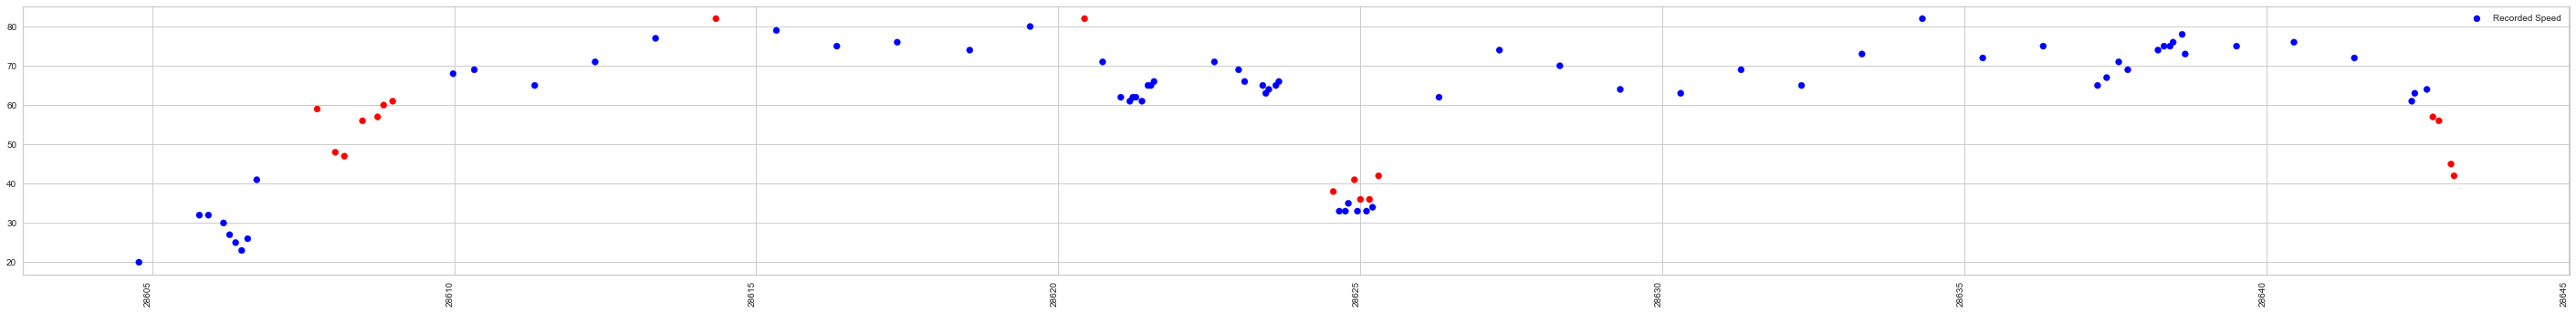

In [379]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates


from matplotlib.pyplot import figure


fig, ax = plt.subplots(1)
fig.autofmt_xdate()

cols = []
for a in dfSubset['Anomaly'].to_list():
    if a == 1:
        cols.append('red')
    else:
        cols.append('blue')

plt.xticks(rotation=90)
plt.scatter(dfSubset['minDiff'], dfSubset['speed'], label = 'Recorded Speed', c = cols)
plt.gray()

#plt.scatter(dates, df['avgSpeed'], label = 'Calculated Speed')

#xfmt = mdates.DateFormatter('%d-%m-%y %H:%M')
# ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=15))
#ax.xaxis.set_major_locator(mdates.HourLocator(interval=3))
#ax.xaxis.set_major_formatter(xfmt)
plt.rcParams["figure.figsize"] = (50,6)

plt.legend(loc="upper right")
#plt.xlim(datetime(2021,7,12,18,0,0), datetime(2021,7,13,4,0,0) )

plt.savefig('Plot.png')

In [403]:
# dfSubset[dfSubset['Anomaly'] == 1]
import plotly.io as pio
from sklearn.cluster import DBSCAN
import numpy as np
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

def plot_cluster(X, y, title="Cluster plot"):
    fig = X.plot.scatter(x='minDiff', y='speed', color=y)
    fig.update_layout(autosize=False, width=1500, height=500,
                  coloraxis = dict(showscale=False, colorscale='Portland'),
                  font=dict(size=18),
                  title=dict(text=title, x=0.5, y=0.95, xanchor='center'))
    fig.update_traces(marker=dict(size=10))
    return fig

pd.options.plotting.backend = 'plotly'
clustering = DBSCAN(eps=3, min_samples=4).fit(np_array[1:])
pred = clustering.labels_

fig = plot_cluster(dfSubset[1:], pred, title="Continuous Only")
fig